<a href="https://colab.research.google.com/github/dinhsang111997/AI/blob/master/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import model
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

In [2]:
from google.colab import drive
labels = os.listdir('/content/drive/MyDrive/input/train')
print(labels)

['Closed', 'yawn', 'no_yawn', 'Open']


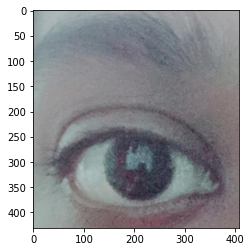

In [4]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('/content/drive/MyDrive/input/train/Open/_341.jpg'))

In [5]:
a=plt.imread('/content/drive/MyDrive/input/train/yawn/115.jpg')
print(a.shape)

(480, 640, 3)


In [6]:
def face_for_yawn(direc="/content/drive/MyDrive/input/train",
                  face_cas_path="/content/drive/MyDrive/xml/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [10]:
def get_data(dir_path="/content/drive/MyDrive/input/train",
             face_cas="/content/drive/MyDrive/xml/haarcascade_frontalface_default.xml",
             eye_cas="/content/drive/MyDrive/xml/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data
data_train = get_data()

2
3


In [11]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)
new_data = append_data()

0
1
2
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [12]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [13]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [14]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [15]:
y = np.array(y)

In [16]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [17]:
len(X_test)

578

In [19]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras

In [20]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [21]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 143, 143, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1

In [22]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
11/43 [======>.......................] - ETA: 4:41 - loss: 1.3665 - accuracy: 0.3472

KeyboardInterrupt: ignored